In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import KernelDensity
from scipy import stats

from torch.distributions import Normal

from mpl_toolkits.axes_grid1 import make_axes_locatable

from typing import Dict, Union, List, Tuple

from itertools import chain

In [2]:
plt.rcParams['figure.figsize'] = (6, 3)

In [3]:
# Sample a batch from the swiss roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

In [4]:
class DotDict(dict):
    """
    a dictionary that supports dot notation 
    as well as dictionary access notation 
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
FIGSIZE=(6,3)

In [6]:
LEGEND=[
    'log $p_{\Theta}(x)$',
    "$E_{\Theta}(x')$, $x' \sim p_{\Theta}(x)$", 
    "$E_{\Theta}(x)$, $x \sim p(x)$"
]

In [7]:
def plot_dataset(model,
                 data, 
                 samples=None,
                 #y=0.0, 
                 plot_score=True,
                 plot_colorbar=True,
                 plot_title=True,
                 custom_title=None,
                 quiver_width=0.002,
                 gt_heatmap=True,
                 gt_pt_size=40,
                 gen_pt_size=40,
                 fig_and_ax=None,
                 figsize=(12,8),
                 xlims=(-1.5, 2.0),
                 ylims=(-1.5, 2.0),
                 fontsize=8):
    
    linspace_N = 50
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, linspace_N), 
                              np.linspace(-1.5, 2.0, linspace_N)), axis=-1).reshape(-1, 2)
    if gt_heatmap:
        ymesh = np.sum(
            np.exp( -(xx - origin)**2 ), axis=1, keepdims=True
        )
    else:
        with torch.no_grad():
            xx_t_cuda = torch.from_numpy(xx).float().cuda()
            ymesh = model.f(xx_t_cuda).detach().cpu().numpy()
    
    xx_cuda = torch.tensor(xx).float().cuda()
    
    #if model is not None:
    scores = model.score(xx_cuda).detach().cpu()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    
    # Perform the plots
    if fig_and_ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = fig_and_ax
    #heatmap.tight_layout()
    
    ############
    #cls_scores = cls(torch.FloatTensor(xx).cuda()).detach().cpu().numpy()
    im = ax.imshow(ymesh.reshape((linspace_N, linspace_N)), 
                   extent=[-1.5, 2.0, -1.5, 2.0], 
                   origin='lower',
                   aspect='auto')
    if plot_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        #cax[1].set_ylabel('y')
        #cbar = ax.colorbar(im)
        #print(cax.axes)
        cax.set_ylabel('y' if gt_heatmap else '$f_{\Theta}(x)$', rotation=0)
        cax.get_yaxis().labelpad = 15
    ############
    
    

    ax.scatter(data[:,0], data[:,1], alpha=0.3, color='orange', s=gt_pt_size, rasterized=True)
    if plot_score:
        ax.quiver(*xx.T, *scores_log1p.T, width=quiver_width)
    else:
        if samples is not None:
            ax.scatter(samples[:,0], samples[:,1], color="black", s=gen_pt_size, marker="x", rasterized=True)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if plot_title:
        if custom_title is None:
            if plot_score:
                ax.set_title("$\\nabla_{x} \ f_{\Theta}(x) = \\nabla_{x}[ -E_{\Theta}(x) ]$",
                             fontsize=fontsize)
            else:
                ax.set_title("samples from MCMC", fontsize=fontsize)
        else:
            ax.set_title(custom_title, fontsize=fontsize)

In [30]:
def plot_samples(models: List[COM], 
                 n_iters: int, 
                 sgld_kwargs: Dict, 
                 gt_heatmap: bool,
                 n_samples: int = 512,
                 prior_bounds: Tuple[float,float] = (-1.5, 2), 
                 log_every: int = 2500,
                 titles: List[str] = None,
                 figsize: Tuple[float,float] = (8,2.5)):
    fig, axes = plt.subplots(1, len(models), figsize=figsize, squeeze=True)
    if len(models) > 1:
        axes = axes.flatten()
    if titles is None:
        titles = ["samples (run {})".format(j+1) for j in range(len(models))]
    for j in range(len(models)):
        this_model = models[j]
        x0 = this_model.sample_x0(n_samples).uniform_(*prior_bounds)
        this_samples = this_model.sample_sgld(n_iters, x0=x0, batch_size=None,
                                              log_every=log_every, **sgld_kwargs)
        this_samples = this_samples.detach().cpu().numpy()
        plot_dataset(this_model, 
                     train_x,
                     plot_score=False,      # do not plot vector arrows
                     samples=this_samples,
                     gt_heatmap=gt_heatmap, # do we use actual y heatmap or f(x)?
                     custom_title=titles[j],
                     xlims=prior_bounds,
                     ylims=prior_bounds,
                     fontsize=13, 
                     gt_pt_size=5,
                     gen_pt_size=5,
                     fig_and_ax=(fig, axes[j] if len(models) > 1 else axes),
                     #figsize=(8,4),
                     #quiver_width=0.005,
                     plot_colorbar=True)
    fig.tight_layout()

---------

# Prepare dataset

In [8]:
data_x = sample_batch(10**4)
data_x.shape

(10000, 2)

In [9]:
origin =  np.asarray([[0.0, 0.0]])
data_y = np.sum( np.exp( -(data_x - origin)**2 ), axis=1, keepdims=True)
data_y.shape

(10000, 1)

In [10]:
def rejection_sample_dataset(data, density_thresh, accept_p):
    mvn = stats.multivariate_normal(np.mean(data_x, axis=0), 1)
    ind = mvn.pdf(data_x) < density_thresh # 0.1
    for j in range(len(ind)):
        if ind[j] == False and np.random.uniform() < accept_p:
            ind[j] = True
    return ind

In [11]:
def prepare_dataset(data_x, data_y, **kwargs):
    ind = rejection_sample_dataset(data_x, **kwargs)
    return {
        "train": (data_x[ind], data_y[ind]),
        "valid": (data_x[~ind], data_y[~ind])
    }

In [12]:
dataset = prepare_dataset(data_x, 
                          data_y, 
                          density_thresh=0.08, 
                          accept_p=0.1)

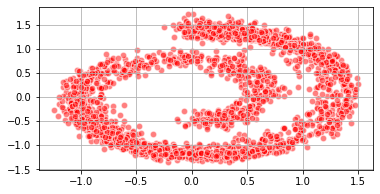

In [13]:
# Plot it
plt.figure(figsize=FIGSIZE)
plt.scatter(dataset["train"][0][:,0], 
            dataset["train"][0][:,1],
            alpha=0.5,
            color='red', 
            edgecolor='white',
            s=40)
plt.grid()

In [14]:
train_x, train_y = dataset["train"][0], dataset["train"][1]
valid_x, valid_y = dataset["valid"][0], dataset["valid"][1]

----------

# Implement EBM-COMs

In [16]:
from typing import Dict

In [17]:
from torch.autograd import grad
from torch.nn.utils import spectral_norm

In [18]:
class Generator(nn.Module):
    def __init__(self, x_dim, n_h=64):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(x_dim, n_h),
            nn.ReLU(),
            nn.Linear(n_h, n_h),
            nn.ReLU(),
            nn.Linear(n_h, 1)
        )
        self.x_dim = x_dim
    def forward(self, x):
        return self.enc(x)

In [19]:
class GeneratorSN(nn.Module):
    def __init__(self, x_dim, n_h=64):
        super().__init__()
        self.enc = nn.Sequential(
            spectral_norm(nn.Linear(x_dim, n_h)),
            nn.ReLU(),
            spectral_norm(nn.Linear(n_h, n_h)),
            nn.ReLU(),
            spectral_norm(nn.Linear(n_h, 1))
        )
        self.x_dim = x_dim
    def forward(self, x):
        return self.enc(x)

In [20]:
class COM:
    def __init__(self,
                 x_dim: int, 
                 alpha: float,
                 gen_kwargs: Dict, 
                 decoupled: bool = False,
                 stochastic: bool = True, # do we use the stochastic variant?
                 std: float = 1.0,  # variance of noise injected before SGLD
                 sgld_n_steps: int = 100,
                 sgld_kwargs: Dict = dict(a=0.001, b=0.0001, gamma=0.33)):
        """
        Conservative objective models, implemented from the perspective of
          an energy-based models (a novel perspective that we have proposed).
        
        Arguments:
         x_dim: dimensionality of input data x
         alpha: controls trade-off between unconditional and conditional estimation,
           i.e. p(x,y) \propto p(x)**alpha * p(y|x).
         gen_kwargs: kwargs for Generator class
         std: standard deviation for Gaussian noise that gets injected into x for
           negative sampling loss (right before sgld gets invoked). This seems to
           be necessary for model convergence.
         sgld_kwargs: dictionary of kwargs for the SGLD function. These parameters
           influence both training and generation.
        """
        self.f = Generator(x_dim, **gen_kwargs).cuda()
        self.cls = None
        if decoupled:
            self.cls = Generator(x_dim, **gen_kwargs).cuda()
            
        #self.f = nn.Identity()
        self.alpha = alpha
        self.x_dim = x_dim
        self.std = std
        self.stochastic = stochastic
        self.sgld_n_steps = sgld_n_steps
        self.sgld_kwargs = sgld_kwargs
    
    def sample_sgld(self, 
                    n_steps: int, 
                    x0: torch.Tensor, 
                    batch_size: int, 
                    *,
                    a: float, 
                    b: float, 
                    gamma: float, 
                    cls_w: float = 1.0,
                    log_every: Union[int, None] = None, 
                    verbose: bool = False):
        if x0 is None and batch_size is None:
            raise ValueError("both x0 and batch_size cannot be None")
        elif x0 is not None and batch_size is not None:
            raise ValueError("batch size does not have any effect if x0 is set")
        else:
            pass
        if x0 is None:
            x0 = self.sample_x0(batch_size)
        
        eps_schedule = get_steps(a, b, gamma, n_steps)

        x = torch.clone(x0)
        x.requires_grad = True
        
        #print("cls_w:", cls_w)

        if verbose:
            pbar = tqdm(total=len(eps_schedule))
        mean_energies = []
        for b, eps in enumerate(eps_schedule):

            # We want to descend the gradient of the energy, but
            # since f(x) = -E(x) we can write it as a gradient ascent
            # on f(x):
            # x := x - E_x
            #    = x - [-f(x)]
            #.   = x + f(x)
            grad_f = grad(self.f(x).sum(), x)[0]
            if self.cls is not None:
                grad_cls = grad(self.cls(x).sum(), x)[0]
            else:
                grad_cls = 0
            
            total_grad = grad_f + cls_w*grad_cls
            
            # sample noise
            if self.stochastic:
                z = torch.zeros_like(x).normal_(0, 1)
            else:
                z = torch.zeros_like(x)

            assert x.shape == total_grad.shape == z.shape
            
            #total_grad = grad_E
            
            # Hope this is the correct way to do it
            x = x + (((eps**2)/2)*total_grad) + eps*z
            x = x.detach()
            x.requires_grad = True

            if verbose:
                pbar.update(1)
                pbar.set_description_str("eps={}".format(eps))
                
            if log_every is not None and b % log_every == 0:
                print("iter: {}, grad norm = {:.3f}".format(b, (total_grad**2).mean()))

        if verbose:
            pbar.close()
        return x
    
    def sample_x0(self, bs):
        return torch.zeros((bs, self.x_dim)).uniform_(-1.5,2).cuda()
    
    def regulariser_loss(self, X_batch, y_batch):
        """The behaviour of this depends on whether the coupled
        or decoupled model is used or not.
        
        For coupled: the energy/regulariser function is E(x) = -f(x),
        and f(x) is also the regression model.
        
        For uncoupled: the energy function is external, we have
        an E_reg(x) that is also a part of the model."""

        # E(x) = -f(x)
        energy_fn = lambda x: -self.f(x)

        E_pos = energy_fn(X_batch)
        perm = torch.randperm(X_batch.size(0))
        noise = torch.zeros_like(X_batch).normal_(0, self.std)
        x_sampled = self.sample_sgld(self.sgld_n_steps, 
                                     X_batch[perm]+noise, 
                                     batch_size=None, 
                                     **self.sgld_kwargs).detach()
        E_neg = energy_fn(x_sampled)
        log_px = (-E_pos + E_neg.mean()).mean()
        
        return log_px, (E_pos, E_neg)
        
    def classifier_loss(self, X_batch, y_batch):
        cls_pred = self.f(X_batch)
        log_pyx = Normal(cls_pred, torch.ones_like(cls_pred)).log_prob(y_batch).mean()
        with torch.no_grad():
            # since f(x) = -E(x)
            cls_mse =  torch.mean((y_batch-cls_pred)**2)
        
        return log_pyx, cls_mse
        
    def classifier_loss_aux(self, X_batch, y_batch):
        cls_aux_pred = self.cls(X_batch)
        log_pyx = Normal(cls_aux_pred, torch.ones_like(cls_aux_pred)).log_prob(y_batch).mean()
        with torch.no_grad():
            # since f(x) = -E(x)
            cls_aux_mse =  torch.mean((y_batch-cls_aux_pred)**2)
        return log_pyx, cls_aux_mse
        
    def train(self, 
              loader, 
              n_epochs, 
              verbose=False,
              use_tqdm = False,
              update_tqdm_every=100,
              log_every=10,
              opt_class=optim.Adam,
              **opt_kwargs) -> Dict:
        """
        max p(x) = max -E(x) + E_{x ~ p_g(x)} E(x)
                 = max f(x) - E_{x ~ p_g(x)} f(x)
                 
        Where p_g(x) is our generative distribution, sampled
        from with SGLD.
        """
        opt_cls = None
        if self.cls is not None:
            opt_cls = opt_class(self.cls.parameters(), **opt_kwargs)
        
        opt_f = opt_class(self.f.parameters(), **opt_kwargs)
            
        buf = DotDict(log_px=[], log_pyx=[], E_neg=[], E_pos=[], cls_mse=[], cls_mse_aux=[])
        for epoch in range(n_epochs):
            losses = []
            fxs = []
            if use_tqdm:
                pbar = tqdm(total=len(loader))
            buf_ = DotDict(log_px=[], log_pyx=[], E_neg=[], E_pos=[], cls_mse=[], cls_mse_aux=[])
            for b, (X_batch, y_batch) in enumerate(loader):
                
                opt_f.zero_grad()
                
                X_batch = X_batch.cuda()
                y_batch = y_batch.cuda()
                
                log_px, (E_pos, E_neg) = self.regulariser_loss(X_batch, y_batch)
                with torch.no_grad():
                    buf_.E_neg.append(E_neg.mean().item())
                    buf_.E_pos.append(E_pos.mean().item())
                    buf_.log_px.append(log_px.item())
                log_pyx, cls_mse  = self.classifier_loss(X_batch, y_batch)
                buf_.log_pyx.append(log_pyx.item())
                buf_.cls_mse.append(cls_mse.item())
                

                joint_ll = self.alpha*log_px + log_pyx
                if b==0 and epoch==0:
                    print("{}*log_px + log_pyx".format(self.alpha))
                (-joint_ll).backward()
                opt_f.step()
                
                if use_tqdm:
                    pbar.update(1)
                    if b % update_tqdm_every == 0:
                        pbar.set_description_str("loss = {:.3f}".format(losses[-1]))
                        
                # ------- external classifier -------
                
                if self.cls is not None:
                    
                    opt_cls.zero_grad()
                    log_pyx_aux, cls_mse_aux  = self.classifier_loss_aux(X_batch, y_batch)
                    with torch.no_grad():
                        buf_.cls_mse_aux.append(cls_mse_aux.item())
                    (-log_pyx_aux).backward()
                    opt_cls.step()
            
            for k,v in buf_.items():
                buf[k].append(np.mean(v))
                
            if verbose and epoch % log_every == 0:
                print({ k:"{:.3f}".format(v[-1]) for k,v in buf.items()})
            
            if use_tqdm:
                pbar.close()
        return buf
    
    def score(self, x):
        x.requires_grad = True
        grad_fx = grad(self.f(x).sum(), x)[0]
        return grad_fx
    
    def __repr__(self):
        return r"""
net = {}
beta = {}
sgld args = {}""".format(self.f, self.beta, self.sgld_kwargs).strip()

In [21]:
def get_steps(a, b, gamma, N, return_ts=False):
    return np.geomspace(a, b, num=N)

In [22]:
train_x, train_y

(array([[ 0.31479819, -1.23268956],
        [ 1.02707201,  0.96550255],
        [ 1.07164959,  0.83774047],
        ...,
        [-0.99355364, -0.13065692],
        [ 0.43077454,  0.89141087],
        [-0.24484202, -1.19021208]]),
 array([[1.12447016],
        [0.74192384],
        [0.81282113],
        ...,
        [1.35571129],
        [1.28238931],
        [1.18434995]]))

# Data loader

In [23]:
from torchvision.transforms import Lambda

In [24]:
Lambda(lambda x: x)

Lambda()

In [25]:
class TransformableTensorDataset(TensorDataset):
    def __init__(self, *args, transform):
        super().__init__(*args)
        self.transform = Lambda(transform)
    def __getitem__(self, idc):
        x, y = super().__getitem__(idc)
        return self.transform(x), y

In [26]:
train_dataset = TransformableTensorDataset(
    torch.from_numpy(train_x).float(),
    torch.from_numpy(train_y).float(),
    transform=lambda x: x,
)
train_dataset

In [27]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training

We learn energy models of the form $p_{\theta}(x,y) \propto p_{\theta}(x)^{\alpha} p_{\theta}(y|x)$, where $\alpha$ weights the unconditional density $p_{\theta}(x)$.

## Stochastic COMs ($\alpha=0$)

In [28]:
SGLD_KWARGS=dict(a=0.02, b=0.0001, gamma=None)

In [ ]:
com0_models = []
for j in range(2):
    com0 = COM(
        x_dim=2, 
        alpha=0.0, 
        gen_kwargs=dict(n_h=256),
        stochastic=True,
        #gen_kwargs={},
        sgld_kwargs=SGLD_KWARGS,
        sgld_n_steps=100,
        std=0.1
    )
    com0_models.append(com0)

In [ ]:
for j in range(2):
    stats = com0_models[j].train(train_loader, n_epochs=50, log_every=10, verbose=1, update_tqdm_every=20)

In [152]:
%%bash
mkdir chkpts_alpha

In [153]:
# For model saving
for j in range(len(com0_models)):
    torch.save(com0_models[j].f.state_dict(), "chkpts_alpha/com0_{}.pth".format(j))

In [154]:
# Model loading
#for j in range(len(com0_models)):
#    com0_models[j].f.load_state_dict( torch.load("chkpts_alpha/com0_{}.pth".format(j)) )

In [155]:
%%bash
mkdir figures_alpha

Plot the energy over time for both +ve (real) and -ve (fake) samples. The energy for real samples should be smaller than that of the fake samples.

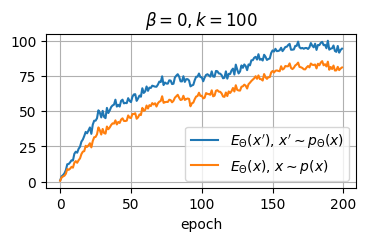

In [78]:
plt.figure(figsize=(4,2))
#plt.plot(stats['log_px'])
plt.plot(stats['E_neg'])
plt.plot(stats['E_pos'])
plt.grid()
plt.legend([
    #'log $p_{\Theta}(x)$',
    "$E_{\Theta}(x')$, $x' \sim p_{\Theta}(x)$", 
    "$E_{\Theta}(x)$, $x \sim p(x)$"
])
plt.xlabel("epoch")
plt.title("$\\beta = 0, k = 100$")
plt.savefig("figures_new/beta0_plot.pdf", bbox_inches='tight')

Plot the gradient vector field.

In [30]:
%%bash
mkdir figures_new

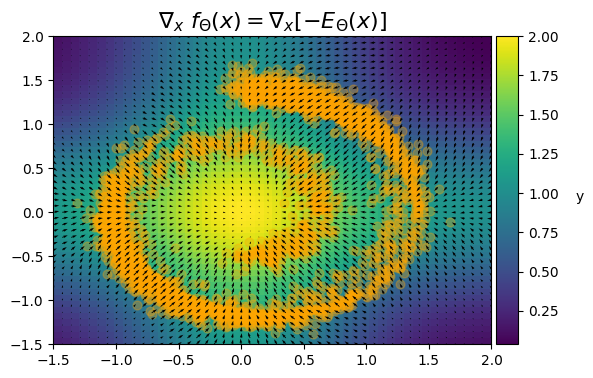

In [173]:
plot_dataset(com0_models[0], 
             train_x, 
             #y=0.75, 
             fontsize=16, 
             #figsize=(10,6),
             figsize=(6,4),
             #quiver_width=0.005,
             plot_colorbar=True)
plt.savefig('figures_alpha/alpha0_quiver.pdf', bbox_inches='tight')

In [80]:
# 292, 358

iter: 0, grad norm = 0.271
iter: 2500, grad norm = 0.065
iter: 5000, grad norm = 0.055
iter: 7500, grad norm = 0.053
iter: 10000, grad norm = 0.058
iter: 12500, grad norm = 0.049
iter: 15000, grad norm = 0.050
iter: 17500, grad norm = 0.046
iter: 20000, grad norm = 0.043
iter: 22500, grad norm = 0.043
iter: 25000, grad norm = 0.045
iter: 27500, grad norm = 0.046
iter: 30000, grad norm = 0.044
iter: 32500, grad norm = 0.044
iter: 35000, grad norm = 0.043
iter: 37500, grad norm = 0.044
iter: 40000, grad norm = 0.045
iter: 42500, grad norm = 0.045
iter: 45000, grad norm = 0.046
iter: 47500, grad norm = 0.045
iter: 0, grad norm = 0.266
iter: 2500, grad norm = 0.083
iter: 5000, grad norm = 0.067
iter: 7500, grad norm = 0.062
iter: 10000, grad norm = 0.057
iter: 12500, grad norm = 0.056
iter: 15000, grad norm = 0.052
iter: 17500, grad norm = 0.058
iter: 20000, grad norm = 0.066
iter: 22500, grad norm = 0.061
iter: 25000, grad norm = 0.061
iter: 27500, grad norm = 0.057
iter: 30000, grad norm

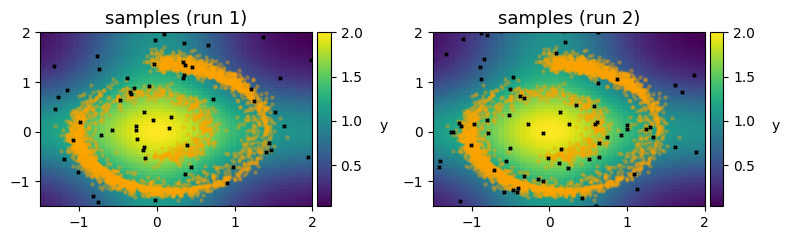

In [161]:
plot_samples(com0_models, 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None})
plt.savefig("figures_alpha/alpha0_samples_grid.pdf", bbox_inches='tight')

## Stochastic COMs ($\alpha=50$)

In [48]:
# No classifier loss here, since alpha == 0.0.
com1_models = []
for j in range(2):
    com1 = COM(
        x_dim=2, 
        alpha=50.0, 
        gen_kwargs=dict(n_h=256),
        stochastic=True,
        #gen_kwargs={},
        sgld_kwargs=SGLD_KWARGS,
        sgld_n_steps=100,
        std=0.1
    )
    com1.train(train_loader, n_epochs=200, log_every=10, verbose=1, update_tqdm_every=20)
    com1_models.append(com1)

opt f: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
50.0*log_px + log_pyx
{'log_px': '0.002', 'log_pyx': '-1.071', 'E_neg': '-0.962', 'E_pos': '-0.964', 'cls_mse': '0.304', 'E_pos_aux': 'nan', 'E_neg_aux': 'nan'}
{'log_px': '0.323', 'log_pyx': '-2.482', 'E_neg': '-0.907', 'E_pos': '-1.230', 'cls_mse': '3.127', 'E_pos_aux': 'nan', 'E_neg_aux': 'nan'}
{'log_px': '0.218', 'log_pyx': '-3.516', 'E_neg': '-0.929', 'E_pos': '-1.147', 'cls_mse': '5.195', 'E_pos_aux': 'nan', 'E_neg_aux': 'nan'}
{'log_px': '0.265', 'log_pyx': '-3.451', 'E_neg': '-0.833', 'E_pos': '-1.097', 'cls_mse': '5.064', 'E_pos_aux': 'nan', 'E_neg_aux': 'nan'}
{'log_px': '0.236', 'log_pyx': '-3.623', 'E_neg': '-0.951', 'E_pos': '-1.187', 'cls_mse': '5.408', 'E_pos_aux': 'nan', 'E_neg_aux': 'nan'}
{'log_px': '0.218', 'log_pyx': '-3.500', 'E_neg': '-0.966', 'E_pos': '-1.184', 'cls_mse': '5.162'

KeyboardInterrupt: 

In [163]:
for j in range(len(com1_models)):
    torch.save(com1_models[j].f.state_dict(), "chkpts_alpha/com1_{}.pth".format(j))

In [164]:
#for j in range(len(com1_models)):
#    com1_models[j].f.load_state_dict( torch.load("chkpts/com1_{}.pth".format(j)) )

In [165]:
com1_models[0].alpha

50.0

iter: 0, grad norm = 2164.086
iter: 2500, grad norm = 367.003
iter: 5000, grad norm = 307.648
iter: 7500, grad norm = 284.489
iter: 10000, grad norm = 306.075
iter: 12500, grad norm = 289.328
iter: 15000, grad norm = 247.192
iter: 17500, grad norm = 241.511
iter: 20000, grad norm = 268.645
iter: 22500, grad norm = 259.803
iter: 25000, grad norm = 244.901
iter: 27500, grad norm = 272.224
iter: 30000, grad norm = 281.314
iter: 32500, grad norm = 248.292
iter: 35000, grad norm = 259.965
iter: 37500, grad norm = 243.351
iter: 40000, grad norm = 257.605
iter: 42500, grad norm = 270.669
iter: 45000, grad norm = 270.036
iter: 47500, grad norm = 249.145
iter: 0, grad norm = 1693.427
iter: 2500, grad norm = 355.107
iter: 5000, grad norm = 320.385
iter: 7500, grad norm = 275.488
iter: 10000, grad norm = 278.186
iter: 12500, grad norm = 261.067
iter: 15000, grad norm = 258.513
iter: 17500, grad norm = 281.398
iter: 20000, grad norm = 247.923
iter: 22500, grad norm = 270.619
iter: 25000, grad norm

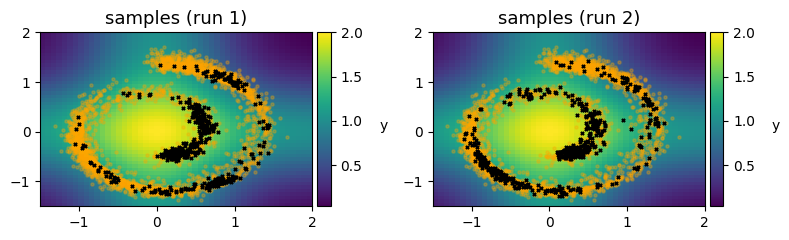

In [169]:
plot_samples(com1_models, 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None})
plt.savefig("figures_alpha/alpha50_samples_grid.pdf", bbox_inches='tight')

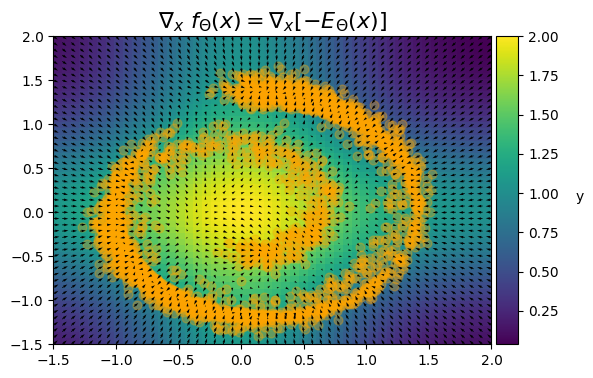

In [49]:
plot_dataset(com1, #com1_models[1], 
             train_x, 
             #y=0.75, 
             fontsize=16, 
             #figsize=(10,6),
             figsize=(6,4),
             #quiver_width=0.005,
             plot_colorbar=True)
#plt.savefig("figures_alpha/alpha50_quiver.pdf", bbox_inches='tight')

## Stochastic COMs ($\alpha \in [0.1, 0.5]$)

In [37]:
# No classifier loss here, since alpha == 0.0.
com2_models = dict()
for alpha in [0.1, 0.5]:
    com2 = COM(
        x_dim=2, 
        alpha=alpha,
        gen_kwargs=dict(n_h=256),
        stochastic=True,
        #gen_kwargs={},
        sgld_kwargs=SGLD_KWARGS,
        sgld_n_steps=100,
        std=0.1
    )
    com2.train(train_loader, n_epochs=200, log_every=10, verbose=1, update_tqdm_every=20)
    com2_models[alpha] = com2
    

0.1*log_px + log_pyx


/home/mila/b/beckhamc/envs/diffusion/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mila/b/beckhamc/envs/diffusion/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'log_px': '-0.003', 'log_pyx': '-1.041', 'E_neg': '-1.075', 'E_pos': '-1.072', 'cls_mse': '0.244', 'cls_mse_aux': 'nan'}
{'log_px': '0.017', 'log_pyx': '-0.920', 'E_neg': '-1.156', 'E_pos': '-1.173', 'cls_mse': '0.001', 'cls_mse_aux': 'nan'}
{'log_px': '0.031', 'log_pyx': '-0.920', 'E_neg': '-1.142', 'E_pos': '-1.173', 'cls_mse': '0.002', 'cls_mse_aux': 'nan'}
{'log_px': '0.048', 'log_pyx': '-0.920', 'E_neg': '-1.126', 'E_pos': '-1.173', 'cls_mse': '0.003', 'cls_mse_aux': 'nan'}
{'log_px': '0.061', 'log_pyx': '-0.921', 'E_neg': '-1.111', 'E_pos': '-1.172', 'cls_mse': '0.004', 'cls_mse_aux': 'nan'}
{'log_px': '0.062', 'log_pyx': '-0.922', 'E_neg': '-1.110', 'E_pos': '-1.172', 'cls_mse': '0.005', 'cls_mse_aux': 'nan'}
{'log_px': '0.080', 'log_pyx': '-0.922', 'E_neg': '-1.093', 'E_pos': '-1.174', 'cls_mse': '0.006', 'cls_mse_aux': 'nan'}
{'log_px': '0.089', 'log_pyx': '-0.923', 'E_neg': '-1.084', 'E_pos': '-1.174', 'cls_mse': '0.008', 'cls_mse_aux': 'nan'}
{'log_px': '0.085', 'log_pyx': 

In [211]:
#for j in range(len(com2_models)):
#    torch.save(com2_models[j].f.state_dict(), "chkpts_alpha/com2_{}.pth".format(j))
    

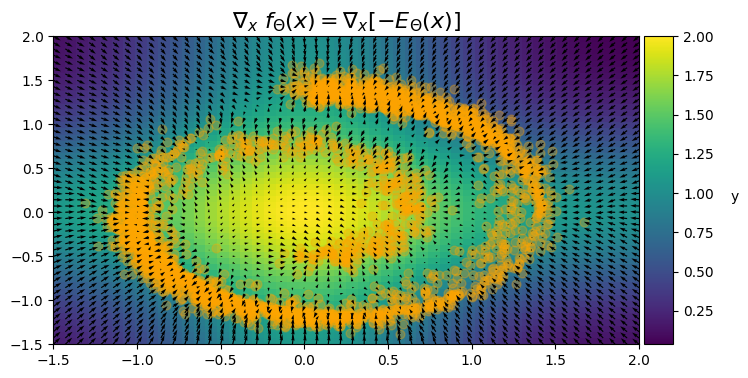

In [175]:
plot_dataset(com2_models[0], 
             train_x, 
             #y=0.75, 
             fontsize=16, 
             #figsize=(10,6),
             figsize=(8,4),
             #quiver_width=0.005,
             plot_colorbar=True)

In [214]:
for elem in com2_models.values():
    print(elem.alpha)

1.0
10.0


In [ ]:
plot_samples(list(com2_models.values()), 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             titles=["alpha=0.1", "alpha=0.5"],
             sgld_kwargs={'a': 0.1, 'b': 1e-5, 'gamma': None})
plt.savefig("figures_alpha/alpha0.1-0.5_samples_grid.pdf", bbox_inches='tight')

iter: 0, grad norm = 138.817
iter: 2500, grad norm = 14.772
iter: 5000, grad norm = 7.920
iter: 10000, grad norm = 12.848
iter: 12500, grad norm = 8.962
iter: 15000, grad norm = 12.009
iter: 17500, grad norm = 7.196
iter: 20000, grad norm = 10.051
iter: 22500, grad norm = 12.831
iter: 25000, grad norm = 12.066
iter: 27500, grad norm = 11.128
iter: 30000, grad norm = 10.749


--------

## Original COMs ($\alpha = 0$)

In [185]:
# No classifier loss here, since alpha == 0.0.
com0_orig_models = []
for j in range(2):
    com0_orig = COM(
        x_dim=2, 
        alpha=0.0, 
        gen_kwargs=dict(n_h=256),
        stochastic=False,
        #gen_kwargs={},
        sgld_kwargs=SGLD_KWARGS,
        sgld_n_steps=100,
        std=0.1
    )
    com0_orig.train(train_loader, n_epochs=50, log_every=10, verbose=1, update_tqdm_every=20)
    com0_orig_models.append(com0_orig)

{'log_px': '-0.004', 'log_pyx': '-1.059', 'E_neg': '-1.141', 'E_pos': '-1.045', 'cls_mse': '0.279'}
{'log_px': '-0.001', 'log_pyx': '-0.919', 'E_neg': '-1.056', 'E_pos': '-1.163', 'cls_mse': '0.000'}
{'log_px': '-0.000', 'log_pyx': '-0.919', 'E_neg': '-1.040', 'E_pos': '-1.163', 'cls_mse': '0.000'}
{'log_px': '-0.000', 'log_pyx': '-0.919', 'E_neg': '-1.047', 'E_pos': '-1.163', 'cls_mse': '0.000'}
{'log_px': '0.000', 'log_pyx': '-0.919', 'E_neg': '-1.046', 'E_pos': '-1.164', 'cls_mse': '0.000'}
{'log_px': '-0.004', 'log_pyx': '-1.053', 'E_neg': '-1.140', 'E_pos': '-1.043', 'cls_mse': '0.269'}
{'log_px': '-0.000', 'log_pyx': '-0.919', 'E_neg': '-1.039', 'E_pos': '-1.163', 'cls_mse': '0.000'}
{'log_px': '-0.001', 'log_pyx': '-0.919', 'E_neg': '-1.038', 'E_pos': '-1.163', 'cls_mse': '0.000'}
{'log_px': '-0.000', 'log_pyx': '-0.919', 'E_neg': '-1.041', 'E_pos': '-1.163', 'cls_mse': '0.000'}
{'log_px': '0.000', 'log_pyx': '-0.919', 'E_neg': '-1.048', 'E_pos': '-1.163', 'cls_mse': '0.000'}


In [190]:
for j in range(len(com0_orig_models)):
    torch.save(com0_orig_models[j].f.state_dict(), "chkpts_alpha/com0-orig_{}.pth".format(j))

In [191]:
#for j in range(len(com0_orig_models)):
#    com0_orig_models[j].f.load_state_dict( torch.load("chkpts_alpha/com0-orig_{}.pth".format(j)) )

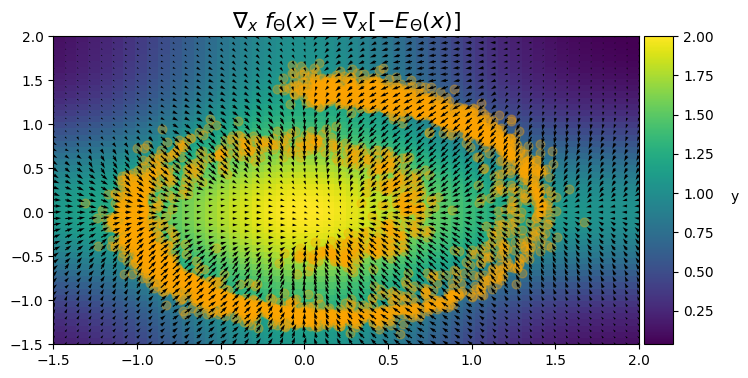

In [186]:
plot_dataset(com0_orig, 
             train_x, 
             #y=0.75, 
             fontsize=16, 
             figsize=(8,4),
             #figsize=(8,4),
             #quiver_width=0.005,
             plot_colorbar=True)
plt.savefig('figures_alpha/alpha0_orig_quiver.pdf', bbox_inches='tight')
#plt.savefig('figures_new/beta0_quiver.pdf', bbox_inches='tight', rasterize=True)

iter: 0, grad norm = 0.270
iter: 2500, grad norm = 0.002
iter: 5000, grad norm = 0.001
iter: 7500, grad norm = 0.001
iter: 10000, grad norm = 0.001
iter: 12500, grad norm = 0.001
iter: 15000, grad norm = 0.000
iter: 17500, grad norm = 0.000
iter: 0, grad norm = 0.257
iter: 2500, grad norm = 0.006
iter: 5000, grad norm = 0.002
iter: 7500, grad norm = 0.002
iter: 10000, grad norm = 0.002
iter: 12500, grad norm = 0.002
iter: 15000, grad norm = 0.002
iter: 17500, grad norm = 0.002


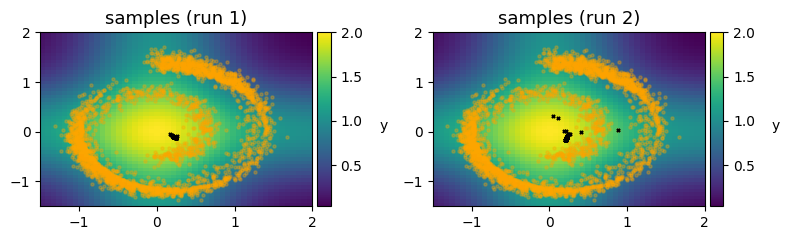

In [189]:
plot_samples(com0_orig_models, 
             n_iters=20000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None})
plt.savefig("figures_alpha/alpha0-orig_samples_grid.pdf", bbox_inches='tight')

-----

## Original COMs ($\alpha=50$)

In [192]:
# No classifier loss here, since alpha == 0.0.
com1_orig_models = []
for j in range(2):
    com1_orig = COM(
        x_dim=2, 
        alpha=50.0, 
        gen_kwargs=dict(n_h=256),
        stochastic=False,
        #gen_kwargs={},
        sgld_kwargs=SGLD_KWARGS,
        sgld_n_steps=100,
        std=0.1
    )
    com1_orig.train(train_loader, n_epochs=200, log_every=10, verbose=1, update_tqdm_every=20)
    com1_orig_models.append(com1_orig)

{'log_px': '-0.000', 'log_pyx': '-1.050', 'E_neg': '-0.897', 'E_pos': '-0.934', 'cls_mse': '0.263'}
{'log_px': '0.137', 'log_pyx': '-1.735', 'E_neg': '3.262', 'E_pos': '-1.159', 'cls_mse': '1.632'}
{'log_px': '0.166', 'log_pyx': '-2.436', 'E_neg': '6.090', 'E_pos': '-1.178', 'cls_mse': '3.034'}
{'log_px': '0.080', 'log_pyx': '-2.341', 'E_neg': '7.518', 'E_pos': '-1.241', 'cls_mse': '2.844'}
{'log_px': '0.147', 'log_pyx': '-2.337', 'E_neg': '8.536', 'E_pos': '-1.111', 'cls_mse': '2.836'}
{'log_px': '0.112', 'log_pyx': '-2.411', 'E_neg': '8.514', 'E_pos': '-1.188', 'cls_mse': '2.984'}
{'log_px': '0.109', 'log_pyx': '-2.967', 'E_neg': '8.914', 'E_pos': '-1.124', 'cls_mse': '4.095'}
{'log_px': '0.071', 'log_pyx': '-2.326', 'E_neg': '9.575', 'E_pos': '-1.130', 'cls_mse': '2.814'}
{'log_px': '0.072', 'log_pyx': '-2.815', 'E_neg': '9.109', 'E_pos': '-1.161', 'cls_mse': '3.791'}
{'log_px': '0.104', 'log_pyx': '-2.261', 'E_neg': '9.124', 'E_pos': '-1.175', 'cls_mse': '2.685'}
{'log_px': '0.082'

In [194]:
for j in range(len(com1_orig_models)):
    torch.save(com1_orig_models[j].f.state_dict(), "chkpts_alpha/com1-orig_{}.pth".format(j))

In [193]:
#for j in range(len(com1_orig_models)):
#    com1_orig_models[j].f.load_state_dict( torch.load("chkpts/com1_orig_{}.pth".format(j)) )

iter: 0, grad norm = 1522.766
iter: 2500, grad norm = 43.350
iter: 5000, grad norm = 41.474
iter: 7500, grad norm = 34.358
iter: 10000, grad norm = 34.628
iter: 12500, grad norm = 33.834
iter: 15000, grad norm = 31.843
iter: 17500, grad norm = 29.765
iter: 20000, grad norm = 34.736
iter: 22500, grad norm = 35.159
iter: 25000, grad norm = 29.757
iter: 27500, grad norm = 29.577
iter: 30000, grad norm = 30.752
iter: 32500, grad norm = 37.666
iter: 35000, grad norm = 27.769
iter: 37500, grad norm = 31.016
iter: 40000, grad norm = 31.547
iter: 42500, grad norm = 22.123
iter: 45000, grad norm = 39.172
iter: 47500, grad norm = 22.307
iter: 0, grad norm = 1693.401
iter: 2500, grad norm = 25.957
iter: 5000, grad norm = 19.180
iter: 7500, grad norm = 24.209
iter: 10000, grad norm = 18.879
iter: 12500, grad norm = 18.646
iter: 15000, grad norm = 16.515
iter: 17500, grad norm = 17.417
iter: 20000, grad norm = 16.814
iter: 22500, grad norm = 18.323
iter: 25000, grad norm = 17.693
iter: 27500, grad 

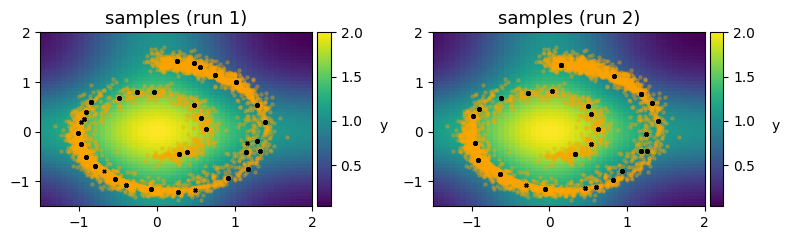

In [203]:
plot_samples(com1_orig_models, 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None})
plt.savefig("figures_alpha/alpha50-orig_samples_grid.pdf", bbox_inches='tight')

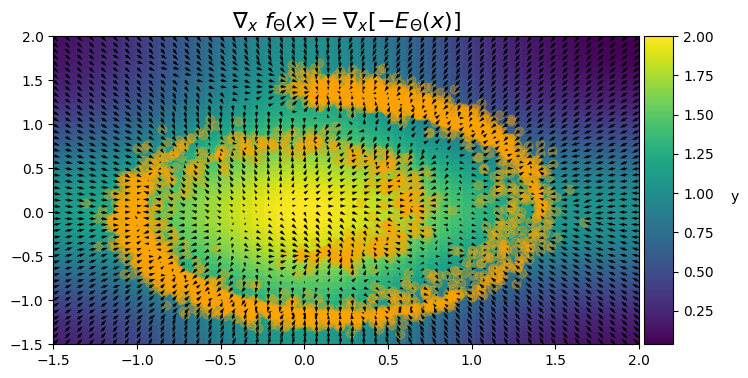

In [200]:
plot_dataset(com1_orig_models[1],
             train_x, 
             #y=0.75, 
             fontsize=16, 
             figsize=(8,4),
             #figsize=(8,4),
             #quiver_width=0.005,
             plot_colorbar=True)

In [73]:
for j in range(len(com1_orig_models)):
    torch.save(com1_orig_models[j].f.state_dict(), "chkpts/com1_orig_{}.pth".format(j))

In [46]:
com0_orig.stochastic

False

---------

In [104]:
# Small weight for the classifier network.
com1 = COM(
    x_dim=2, 
    beta=1.0, 
    gen_kwargs={},
    sgld_kwargs=dict(a=0.001, b=0.0001, gamma=0.33, n_steps=100),
    std=0.1
)
com1

net = Generator(
  (enc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
beta = 1.0
sgld args = {'a': 0.001, 'b': 0.0001, 'gamma': 0.33, 'n_steps': 100}

In [106]:
#stats1 = com1.train(train_loader, n_epochs=40, verbose=1, update_tqdm_every=20)

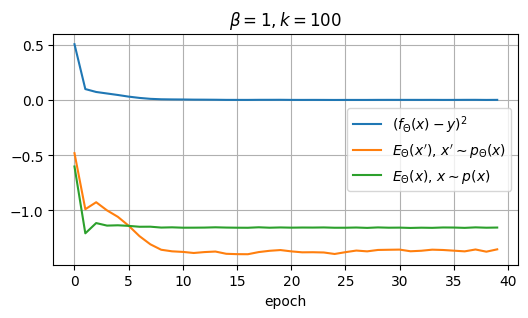

In [109]:
plt.figure(figsize=FIGSIZE)
plt.plot(stats1['cls_mse'])
plt.plot(stats1['E_neg'])
plt.plot(stats1['E_pos'])
plt.grid()
plt.legend([
    '$(f_{\Theta}(x) - y)^2$',
    "$E_{\Theta}(x')$, $x' \sim p_{\Theta}(x)$", 
    "$E_{\Theta}(x)$, $x \sim p(x)$"
])
plt.xlabel("epoch")
plt.title("$\\beta = 1, k = 100$")
plt.savefig("figures/beta1.0_plot.pdf", bbox_inches='tight')

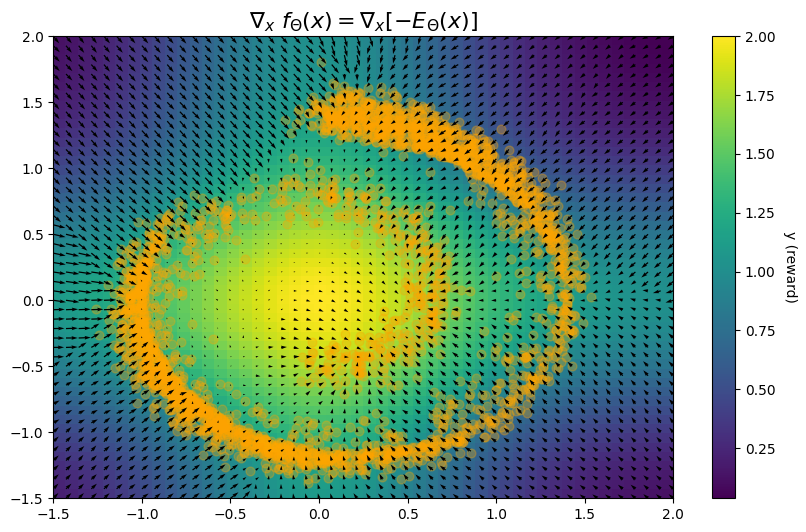

In [177]:
plot_dataset(com1, 
             train_x, 
             #y=0.75, 
             sigma=0.01, 
             fontsize=16, 
             figsize=(10,6),
             #figsize=(8,4),
             #quiver_width=0.005,
             plot_colorbar=True)
#plt.savefig('xy0.pdf', bbox_inches='tight'4
#plt.savefig("figures/beta0.1_plot.pdf", bbox_inches='tight')
plt.savefig('figures/beta1.0_quiver.pdf', bbox_inches='tight')

------

## Decoupled classifier

In [107]:
com_dc = COM(
    x_dim=2, 
    alpha=50.0, 
    decoupled=True,
    gen_kwargs=dict(n_h=256),
    stochastic=True,
    #gen_kwargs={},
    sgld_kwargs=SGLD_KWARGS,
    sgld_n_steps=100,
    std=0.1
)

In [108]:
com_dc.cls

Generator(
  (enc): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [92]:
_=com_dc.train(train_loader, n_epochs=200, log_every=10, verbose=1, update_tqdm_every=20, lr=2e-4,)


50.0*log_px + log_pyx
{'log_px': '-0.000', 'log_pyx': '-1.330', 'E_neg': '-0.327', 'E_pos': '-0.327', 'cls_mse': '0.823', 'cls_mse_aux': '0.448'}
{'log_px': '0.060', 'log_pyx': '-0.994', 'E_neg': '-1.084', 'E_pos': '-1.144', 'cls_mse': '0.150', 'cls_mse_aux': '0.008'}
{'log_px': '0.198', 'log_pyx': '-1.166', 'E_neg': '-0.981', 'E_pos': '-1.179', 'cls_mse': '0.495', 'cls_mse_aux': '0.001'}
{'log_px': '0.255', 'log_pyx': '-1.516', 'E_neg': '-0.969', 'E_pos': '-1.224', 'cls_mse': '1.193', 'cls_mse_aux': '0.000'}
{'log_px': '0.358', 'log_pyx': '-2.311', 'E_neg': '-0.806', 'E_pos': '-1.163', 'cls_mse': '2.784', 'cls_mse_aux': '0.000'}
{'log_px': '0.317', 'log_pyx': '-3.033', 'E_neg': '-0.889', 'E_pos': '-1.207', 'cls_mse': '4.228', 'cls_mse_aux': '0.000'}
{'log_px': '0.311', 'log_pyx': '-3.359', 'E_neg': '-0.861', 'E_pos': '-1.171', 'cls_mse': '4.880', 'cls_mse_aux': '0.000'}
{'log_px': '0.334', 'log_pyx': '-3.521', 'E_neg': '-0.846', 'E_pos': '-1.180', 'cls_mse': '5.204', 'cls_mse_aux': '0

In [94]:
#com_dc.f = com_dc.reg

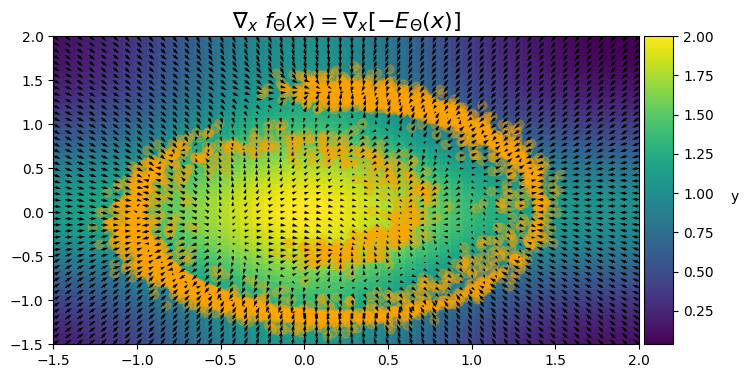

In [103]:
plot_dataset(com_dc, 
             train_x, 
             #y=0.75, 
             fontsize=16, 
             figsize=(8,4),
             #figsize=(8,4),
             #quiver_width=0.005,
             plot_colorbar=True)

In [100]:
#torch.save( (com_dc.f.state_dict(), com_dc.cls.state_dict()), "chkpts_alpha/com_dc.pth")

In [109]:
com_dc.f.load_state_dict( torch.load("chkpts_alpha/com_dc.pth")[0] )
com_dc.cls.load_state_dict( torch.load("chkpts_alpha/com_dc.pth")[1] )

<All keys matched successfully>

In [97]:
#com_dc.alpha=1.0
#com_dc.stochastic=True

In [104]:
com_dc.alpha

50.0

iter: 0, grad norm = 1451.451
iter: 2500, grad norm = 395.875
iter: 5000, grad norm = 328.908
iter: 7500, grad norm = 307.988
iter: 10000, grad norm = 287.638
iter: 12500, grad norm = 289.305
iter: 15000, grad norm = 271.967
iter: 17500, grad norm = 308.717
iter: 20000, grad norm = 287.682
iter: 22500, grad norm = 280.459
iter: 25000, grad norm = 258.872
iter: 27500, grad norm = 278.403
iter: 30000, grad norm = 263.959
iter: 32500, grad norm = 257.142
iter: 35000, grad norm = 272.330
iter: 37500, grad norm = 263.039
iter: 40000, grad norm = 260.860
iter: 42500, grad norm = 253.824
iter: 45000, grad norm = 264.111
iter: 47500, grad norm = 259.611


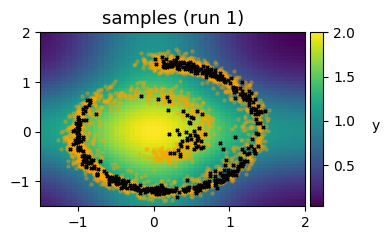

In [119]:
plot_samples([ com_dc ], 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None, 'cls_w': 0.}, 
             figsize=(4,2.5))
plt.savefig("figures_new/com_dc_w0.pdf", bbox_inches='tight')

iter: 0, grad norm = 1546.007
iter: 2500, grad norm = 152.695
iter: 5000, grad norm = 150.881
iter: 7500, grad norm = 158.784
iter: 10000, grad norm = 188.764
iter: 12500, grad norm = 153.154
iter: 15000, grad norm = 156.597
iter: 17500, grad norm = 146.117
iter: 20000, grad norm = 153.226
iter: 22500, grad norm = 150.812
iter: 25000, grad norm = 147.997
iter: 27500, grad norm = 142.324
iter: 30000, grad norm = 158.219
iter: 32500, grad norm = 152.132
iter: 35000, grad norm = 160.787
iter: 37500, grad norm = 158.107
iter: 40000, grad norm = 154.509
iter: 42500, grad norm = 153.394
iter: 45000, grad norm = 144.975
iter: 47500, grad norm = 149.763


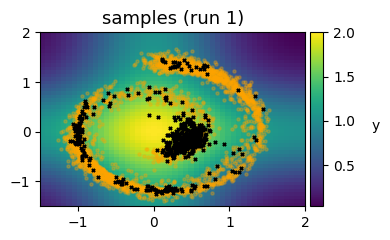

In [120]:
plot_samples([ com_dc ], 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None, 'cls_w': 5.}, 
             figsize=(4,2.5))
plt.savefig("figures_new/com_dc_w5.pdf", bbox_inches='tight')
#plt.savefig("figures_new/com_dc_beta{}.pdf".format(beta), bbox_inches='tight')

In [122]:
%%bash
cp figures_new/com_dc*.pdf figures_alpha

iter: 0, grad norm = 1545.903
iter: 2500, grad norm = 66.715
iter: 5000, grad norm = 60.516
iter: 7500, grad norm = 65.821
iter: 10000, grad norm = 64.562
iter: 12500, grad norm = 56.722
iter: 15000, grad norm = 56.072
iter: 17500, grad norm = 63.995
iter: 20000, grad norm = 65.929
iter: 22500, grad norm = 62.512
iter: 25000, grad norm = 63.951
iter: 27500, grad norm = 63.138
iter: 30000, grad norm = 51.885
iter: 32500, grad norm = 57.912
iter: 35000, grad norm = 61.274
iter: 37500, grad norm = 55.455
iter: 40000, grad norm = 59.343
iter: 42500, grad norm = 55.148
iter: 45000, grad norm = 57.332
iter: 47500, grad norm = 56.479


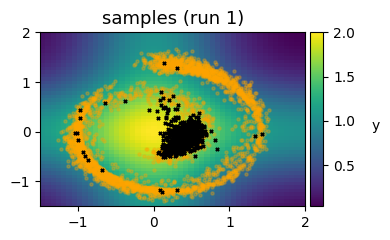

In [121]:
plot_samples([ com_dc ], 
             n_iters=50000, 
             gt_heatmap = True, #beta=0 so yes
             sgld_kwargs={'a': 0.1, 'b': 1e-4, 'gamma': None, 'cls_w': 10.}, 
             figsize=(4,2.5))
plt.savefig("figures_new/com_dc_w10.pdf", bbox_inches='tight')
#plt.savefig("figures_new/com_dc_beta{}.pdf".format(beta), bbox_inches='tight')

In [73]:
com_dc.cls

Generator(
  (enc): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [77]:
com_dc.energy

<bound method COM.energy of net = Generator(
  (enc): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
beta = 50.0
sgld args = {'a': 0.02, 'b': 0.0001, 'gamma': None}>